In [1]:
import numpy as np
import os
from sklearn.manifold import TSNE
import paddle
import torch

In [2]:
torch.set_default_dtype(torch.float32)
paddle.set_default_dtype("float32")

DFT数据存放路径
---
The path to store DFT data

In [3]:
dir_file = '/Users/junjiehu/Mlearning/MaterialsML/DFT-bluk-cpx222/'

遍历文件路径
---
Traversing the file path

In [4]:
flag_set=[]
file_path_set=[]
work_path=dir_file
for m1,n1,fname in os.walk(work_path):
    for ieach in n1:
        flag_set.append(ieach)
        ieach=work_path+ieach
        file_path_set.append(ieach)

从POSCAR文件中提取文本信息
---
Extracting structural information from POSCAR files

In [5]:
def extract(flodername):    
    with open(flodername+'/'+'CONTCAR') as f:
        lol=[line.strip().split('\n') for line in f]#逐行读取，并存储为数组结构
    matr_s_o=[]#存放晶格常数的3*3数组    
    matr_o=[]
    
    formula_element=''#存放原子类型
    amount_element=''#存放晶胞中原子个数
    
    matr_data_o=[]
    matr_data_0=[]
    matr_data=[]
    for i in lol[2:5]:

        jjj=[]

        for j in i[0].split(' '):
            if j !='':
                jjj.append(j)

        matr_s_o.append(jjj)
   
    for k in matr_s_o:
        matr_o.append([float(l) for l in k])
    
    amount_element=lol[5]
    
    for n in lol[9:49]:#文件第10行开始读数据

        n[0]=n[0][:-10]
        mmm=[]
        for m in n[0].split(' '):
        #        print(m)
            if m !='':
                mmm.append(m)
           # print(mmm)
        matr_data_o.append(mmm)
        
    for p in matr_data_o:
        matr_data_0.append([float(q) for q in p]) 
    
    matr_out=matr_o
    amount_element_out=amount_element[0]
    matr_data_0=matr_data_0
    
    return matr_out, amount_element_out, matr_data_0

文件信息提取测试

In [6]:
#floder_name = dir_file + '00000'

In [7]:
#xxxx = extract(floder_name)

In [8]:
#xxxx[0]

In [9]:
#xxxx[1]

In [10]:
#len(xxxx[2])

从2\*2\*2的ABX3超胞中提取结构信息为基础构造tSNE输入向量
---
Constructing tSNE input vectors based on structural information extracted from 2\*2\*2 ABX3 supercells

In [11]:
def get_tSNE_input(path_):
    input_vector_poscar=[]
    a,b,c=extract(path_)
    #energy=get_energy(path_)
    siteZero=np.asarray([0.5,0.5,0.5])
    Br_I_atoms=c[16:]
    coordinate=np.dot(np.asarray(Br_I_atoms),np.asarray(a))
    #print(len(coordinate))
    for i in range(len(coordinate)):
        input_vector=[]
        if i <=18:
            #print(coordinate[i])
            input_vector.append(2.8)
            for x in coordinate[i]:
                input_vector.append(x)
            input_vector_poscar.append(input_vector)
        else:
            input_vector.append(2.5)
            for x in coordinate[i]:
                input_vector.append(x)
            input_vector_poscar.append(input_vector)
    input_vector_poscar=np.asarray(input_vector_poscar)
    input_vector_poscar=input_vector_poscar.reshape((24*4),order="C")
    return input_vector_poscar

函数测试

In [12]:
#get_tSNE_input(floder_name)

从文件路径中提取结构的能量值
---
Extracting the energy value of a structure from a file path

In [13]:
def get_energy(foldername):
    energy_string=os.popen('grep TOTEN '+foldername+'/OUTCAR | tail -1').read().split(' ')[-2]
    energy=round(np.float64(float(energy_string)),5)
    return energy

函数测试

In [14]:
#type(get_energy(floder_name))

加载GCN模型从结构文件中预测能量值
---
Loading GCN model to predict energy values from structure files

In [15]:
import re
import pymatgen as mg
import pymatgen.analysis.diffraction as anadi
import pymatgen.analysis.diffraction.xrd as xrd
import glob
import torch
import torch.nn as nn
from torch.autograd import Variable
import math

In [16]:
def linear_transform(energy):
    global extend_num, move_num
    energy_transform=(energy-move_num)*extend_num
    return energy_transform
def inverse_transform(energy_transform):
    global extend_num, move_num
    energy=energy_transform/extend_num+move_num
    return energy
def get_energy_per_atom(energy):
    energy_per_atom=energy/atoms_num
    return energy_per_atom

#def init_hyperparameters():

In [17]:

torch.set_default_dtype(torch.float64)

torch.set_printoptions(precision=8)

patt_xrd = xrd.XRDCalculator('CuKa')

global sample_num, rmat_num, series_num
sample_num=1 #output of G
rmat_num=28  #row nums of the matrix for the input of CNN 
#series_num=3 #input of D
global extend_num, move_num
extend_num=1000
move_num=get_energy(dir_file+'00000/')

从结构文件中处理得到xrd数据，并产生输入文件

In [18]:
base_pxrd_s=mg.core.Structure.from_file(dir_file+'/00000/CONTCAR')
base_pxrd=patt_xrd.get_pattern(base_pxrd_s)

In [19]:
def random_xxpsk(file_path):
    folder=np.random.choice(glob.glob(file_path +"*"))
    #pos_name=folder+'/POSCAR'
    #out_name=folder+'/OUTCAR'
    return folder

def tomgStructure(folder):
    POSfile=folder+'/CONTCAR'      
    R_mgS=mg.core.Structure.from_file(POSfile)
    return R_mgS

###
##input_data_to_model
###
def get_xrdmat3(mgStructure):
    global rmat_num
    xrd_data4 =patt_xrd.get_pattern(mgStructure)
    xrd_data4.y=xrd_data4.y-base_pxrd.y
    i_column = rmat_num
    xxx=[]
    yyy=[]
    mat4=[]
    xrd_i=len(xrd_data4)
    for i in range(xrd_i):
        if abs(xrd_data4.y[i])>0.00001:
            xxx.append(xrd_data4.x[i])
            yyy.append(xrd_data4.y[i])
    mat4.append(np.asarray(xxx))
    mat4.append(np.asarray(yyy))
    mat4=np.asarray(mat4)
    
    xrd_x=[]
    xrd_y=[]
    xrd_mat4=[]
    xrow=len(mat4[0])
    
    if xrow < i_column:
        for i in mat4[0]:
            xrd_x.append(i)
        for j in mat4[1]:
            xrd_y.append(j)
        for i in range(0,i_column-xrow):
            xrd_x.append(0)
            xrd_y.append(0)
        xrd_x=np.asarray(xrd_x)
        xrd_y=np.asarray(xrd_y)
    if xrow > i_column:
        xrd_x=mat4[0][:i_column]
        xrd_y=mat4[1][:i_column]
    if xrow == i_column:
        xrd_x= mat4[0]
        xrd_y= mat4[1]
        
    
    xrd_x=np.sin(np.dot(1/180*np.pi,xrd_x))
    xrd_y=np.dot(100,xrd_y)
    xrd_mat4.append(xrd_x)
    xrd_mat4.append(xrd_y)
    xrd_mat4=np.array(xrd_mat4)
    return xrd_mat4

def get_atoms_num(folder2):
    xxx=tomgStructure(folder2)
    anum=len(xxx.sites)
    return anum

def GANs_Gmat(Random_Structure):
    global rmat_num
    RS_xrdmat = get_xrdmat3(Random_Structure)
    multimat3_RS =  np.zeros((rmat_num,rmat_num),dtype='float32')
    multimat3_RS = np.asarray((np.dot(RS_xrdmat.T, RS_xrdmat)))
    return multimat3_RS

预测模型结构

In [20]:
class GCNNet(nn.Module):
    def __init__(self, input_size=(sample_num,28,28)):
        super(GCNNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(#(3,28,28)
                in_channels=sample_num,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2,
            ),#->(32,28,28)
            nn.ReLU(),#->(32,28,28)
            nn.MaxPool2d(kernel_size=2),
        )#->(#->(32,14,14))
        self.conv2=nn.Sequential(#->(32,14,14))
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=5,
                stride=1,
                padding=2,
            ),#->(64,14,14)
            nn.ReLU(),#->(64,14,14)
            nn.MaxPool2d(kernel_size=2),#->(64,7,7)
        )
        self.out=nn.Sequential(
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Linear(128,sample_num),            
        )
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x) #batch(64,7,7)
        x=x.view(x.size(0),-1) #(batch, 64*7*7)
        output=torch.unsqueeze(self.out(x),dim=0)
        return output

加载模型

In [21]:
G1= GCNNet()
G1.load_state_dict(torch.load('/Users/junjiehu/Desktop/202210test/G1_GCN-1.pkl'))

<All keys matched successfully>

In [22]:
def model_predict(floder):
    #input
    model_input=[]
    model_input_mgs=tomgStructure(floder)
    model_input_mgs=GANs_Gmat(model_input_mgs)
    model_input.append(model_input_mgs)
    model_input=np.asarray(model_input)
    model_input=model_input[np.newaxis,:,:,:]
    model_input=np.asarray(model_input,dtype=np.float64)
    model_input=Variable(torch.from_numpy(model_input),requires_grad=True)
    #torch_model predicts the output
    model_output=G1(model_input)
    total_value_model=model_output.data.numpy().mean()
    total_energy_model=inverse_transform(total_value_model)
    return total_energy_model

In [23]:
model_predict(file_path_set[0])

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


-122.69683542659132

加载WSP-Gen生成模型并预测能量
---
Loading the WSP-Gen generative model and predicting energy

In [25]:
class GNet(nn.Module):
    
    def __init__(self, input_size=(sample_num,28,28)):
        super(GNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(#(3,28,28)
                in_channels=sample_num,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2,
            ),#->(32,28,28)
            nn.ReLU(),#->(32,28,28)
            nn.MaxPool2d(kernel_size=2),
        )#->(#->(32,14,14))
        self.conv2=nn.Sequential(#->(32,14,14))
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=5,
                stride=1,
                padding=2,
            ),#->(64,14,14)
            nn.ReLU(),#->(64,14,14)
            nn.MaxPool2d(kernel_size=2),#->(64,7,7)
        )
        self.out=nn.Sequential(
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Linear(128,sample_num),            
        )
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x) #batch(64,7,7)
        x=x.view(x.size(0),-1) #(batch, 64*7*7)
        output=torch.unsqueeze(self.out(x),dim=0)
        return output

In [26]:
G2=GNet()
G2.load_state_dict(torch.load('/Users/junjiehu/Desktop/202210test/G1_cpx222_516-t3-s5.pkl'))

<All keys matched successfully>

In [27]:
def WSPmodel_predict(floder):
    #input
    model_input=[]
    model_input_mgs=tomgStructure(floder)
    model_input_mgs=GANs_Gmat(model_input_mgs)
    model_input.append(model_input_mgs)
    model_input=np.asarray(model_input)
    model_input=model_input[np.newaxis,:,:,:]
    model_input=np.asarray(model_input,dtype=np.float64)
    model_input=Variable(torch.from_numpy(model_input),requires_grad=True)
    #torch_model predicts the output
    model_output=G2(model_input)
    total_value_model=model_output.data.numpy().mean()
    total_energy_model=inverse_transform(total_value_model)
    return total_energy_model

In [28]:
WSPmodel_predict(file_path_set[0])

-122.69004461716636

加载Quantum Machine Learning模型并预测能量
---
Loading Quantum Machine Learning models and predicting energy

In [29]:
import paddle
from paddle import fluid
#from paddle_quantum.circuit import UAnsatz
from paddle_quantum.ansatz import Circuit
from paddle_quantum.qinfo import state_fidelity, partial_trace, pauli_str_to_matrix, NKron
from paddle_quantum.linalg import dagger, haar_unitary
#from paddle_quantum.utils import partial_trace, dagger, state_fidelity, NKron,pauli_str_to_matrix
from paddle import complex
from paddle import matmul, trace, kron#,elementwise_add
from sklearn import preprocessing

In [30]:
import xrd4QML
from xrd4QML import tomgStructure, get_xrdmat
import paddle_qcnn_5bits_5to4

/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


In [31]:
from torch.autograd import Variable

In [32]:
def xrdpre_process(xrd_path):
    xrd1=xrd_path
    xrd2=tomgStructure(xrd1)
    xrd3=np.nan_to_num(get_xrdmat(xrd2))
    xrd4=preprocessing.normalize(np.array([xrd3]), norm="l2", axis=1)
    xrd5=np.dot(xrd4.T,xrd4)
    xrd6=xrd5.astype('complex64')
    return xrd6

In [33]:
theta_load=np.asarray([1.50826, 2.16304, 3.54938, 3.59472, 2.57092, 5.31218, 3.19765, -0.364409,
                       5.19505, 4.66239, 6.03654, 2.37409, 2.89946, 0.0742845, 0.731149, 5.05812, 
                       2.37495, -0.540096, 3.20501, 3.07696, -1.39899])

In [34]:
class Net_3(nn.Module):
    def __init__(self):
        super(Net_3, self).__init__()
        
        self.out=nn.Sequential(
            nn.Linear(4,32),
            nn.ReLU(),
            nn.Linear(32,1),            
        )
        
    def forward(self,x):
        x=x.view(x.size(0),-1)
        output=self.out(x)
        return output

In [35]:
load_net1=paddle_qcnn_5bits_5to4.load_NET_2(theta_load)
HQMLmodel= Net_3()
HQMLmodel.load_state_dict(torch.load("/Users/junjiehu/Desktop/202210test/net3.pth"))

<All keys matched successfully>

In [36]:
def QMLmodel_predict(floder):
    #input
    input_xrd=xrdpre_process(floder)
    a_out,c_encode=load_net1(input_xrd)
    input_net3=paddle_qcnn_5bits_5to4.measure_Z(c_encode)
    input_net3=np.asarray([[input_net3]])
    input_net3=np.asarray(input_net3,dtype=np.float64)
    input_net3=torch.Tensor(input_net3)
    Gout=HQMLmodel(input_net3)
    G_data=Gout.data.numpy().mean()
    total_energy_model = xrd4QML.inverse_transform(G_data)
    return total_energy_model

In [37]:
QMLmodel_predict(file_path_set[0])

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

-122.69322042602539

In [38]:
'''
DFT_energy=[]
QML_energy=[]
for path_ in workfile:
    try:
        dft_energy= xrd4QML.get_energy(path_)
        input_xrd=xrdpre_process(path_)
        a_out,c_encode=load_net1(input_xrd)
        input_net3=paddle_qcnn_5bits_5to4.measure_Z(c_encode)
        input_net3=np.asarray([[input_net3]])
        input_net3=np.asarray(input_net3,dtype=np.float64)
        input_net3=torch.Tensor(input_net3)
        Gout=HQMLmodel(input_net3)
        G_data=Gout.data.numpy().mean()
        QML_energy.append(xrd4QML.inverse_transform(G_data))
        DFT_energy.append(dft_energy)
    except:
        print(path_)
'''

'\nDFT_energy=[]\nQML_energy=[]\nfor path_ in workfile:\n    try:\n        dft_energy= xrd4QML.get_energy(path_)\n        input_xrd=xrdpre_process(path_)\n        a_out,c_encode=load_net1(input_xrd)\n        input_net3=paddle_qcnn_5bits_5to4.measure_Z(c_encode)\n        input_net3=np.asarray([[input_net3]])\n        input_net3=np.asarray(input_net3,dtype=np.float64)\n        input_net3=torch.Tensor(input_net3)\n        Gout=HQMLmodel(input_net3)\n        G_data=Gout.data.numpy().mean()\n        QML_energy.append(xrd4QML.inverse_transform(G_data))\n        DFT_energy.append(dft_energy)\n    except:\n        print(path_)\n'

其它预测模型
---

In [39]:
#SVMmodel

构造tSNE的输入和能量标签
----

In [41]:
tSNE_input=[]
flag=[]
energy_set_DFT=[]
energy_set_model=[]
energy_set_WSPmodel=[]
energy_set_QMLmodel=[]
for pnum in range(len(file_path_set)):
    try:
        path_=file_path_set[pnum]
        flag.append(flag_set[pnum])
        energy_set_DFT.append(get_energy(path_))
        tSNE_input.append(get_tSNE_input(path_))
        energy_set_model.append(model_predict(path_))
        energy_set_WSPmodel.append(WSPmodel_predict(path_))
        energy_set_QMLmodel.append(QMLmodel_predict(path_))
    except:
        print('error:',file_path_set[pnum])

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

/Users/junjiehu/Desktop/202210test/PCCP-code/xrd4QML.py:85: RuntimeWarning: invalid value encountered in true_divide
  xrd_z=xrd_y/xrd_x
/Users/junjiehu/Desktop/202210test/PCCP-code/paddle_qcnn_5bits_5to4.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype('float32')
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this w

运行tSNE算法处理结构数据
----
Run the tSNE algorithm to process structural data

In [42]:
tsne = TSNE(min_grad_norm=1e-3,init='pca',method='exact',angle=1,early_exaggeration=5,n_iter=1000)

In [43]:
tSNE_input = np.asarray(tSNE_input)

In [44]:
tsne_output = tsne.fit_transform(tSNE_input)

/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/junjiehu/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


可视化-A
---
Visualisation: Scheme A

In [45]:
import matplotlib.pyplot as plt

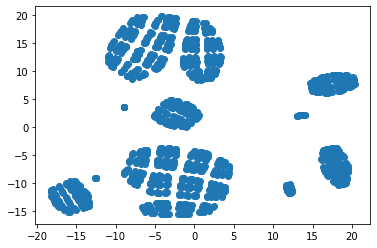

In [46]:
plt.scatter(tsne_output.T[0],tsne_output.T[1])

可视化-B
---
Visualisation: Scheme B

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages

In [50]:
energy_set_DFT=[]
for pnum in range(len(file_path_set)):
    try:
        path_=file_path_set[pnum]
        energy_set_DFT.append(get_energy(path_))
    except:
        print('error:',file_path_set[pnum])

In [77]:
z1 = np.asarray(energy_set_DFT)
z2 = np.asarray(energy_set_model)
z3 = np.asarray(energy_set_WSPmodel)
z4 = np.asarray(energy_set_QMLmodel)

DFT

In [65]:
x = tsne_output.T[0]
y = tsne_output.T[1]

In [66]:
labels = flag

In [110]:
minz = np.min(z1)
maxz = np.max(z1)
print('minimum:',minz)
print('maximum:',maxz)
print('scale:',maxz-minz)
a1 = minz + 0.2 * (maxz-minz)
a2 = minz + 0.4 * (maxz-minz)
a3 = minz + 0.6 * (maxz-minz)
a4 = minz + 0.8 * (maxz-minz)
print(minz,a1,a2,a3,a4,maxz)

minimum: -122.70765
maximum: -122.68028
scale: 0.02737000000000478
-122.70765 -122.702176 -122.696702 -122.691228 -122.685754 -122.68028


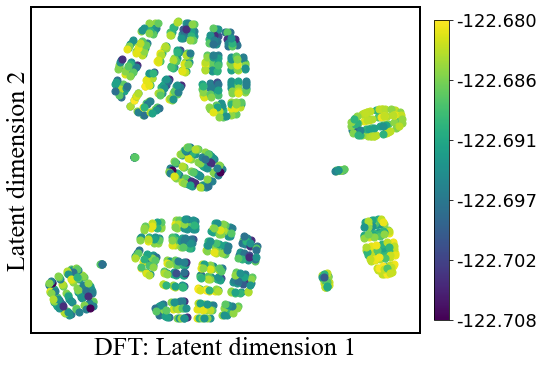

In [111]:
f=plt.figure(figsize=(8.5,6))
ax1=plt.gca()

#j=1088
for i in range(len(x)):
    color1=cm.viridis_r(int(256*(z1[i]-minz)/(maxz-minz)))
    a1=ax1.scatter(x[i],y[i],color=color1,s=50)
    #d=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
cb=plt.colorbar(a1,ax=ax1,shrink=0.92,pad=0.03)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_yticklabels(['-122.708', '-122.702', '-122.697', '-122.691', '-122.686', '-122.680'])
cb.ax.tick_params(labelsize=18)
ax1.set_xlabel('DFT: Latent dimension 1',fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.set_ylabel('Latent dimension 2',labelpad=0,fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.tick_params(labelsize=22)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.set_xticks(())
ax1.set_yticks(())
plt.savefig('DFT.jpg')

supervised machine learning

In [112]:
minz = np.min(z2)
maxz = np.max(z2)
print('minimum:',minz)
print('maximum:',maxz)
print('scale:',maxz-minz)
a1 = minz + 0.2 * (maxz-minz)
a2 = minz + 0.4 * (maxz-minz)
a3 = minz + 0.6 * (maxz-minz)
a4 = minz + 0.8 * (maxz-minz)
print(minz,a1,a2,a3,a4,maxz)

minimum: -122.72459207909321
maximum: -122.68189847772022
scale: 0.04269360137298861
-122.72459207909321 -122.71605335881861 -122.70751463854401 -122.69897591826943 -122.69043719799483 -122.68189847772022


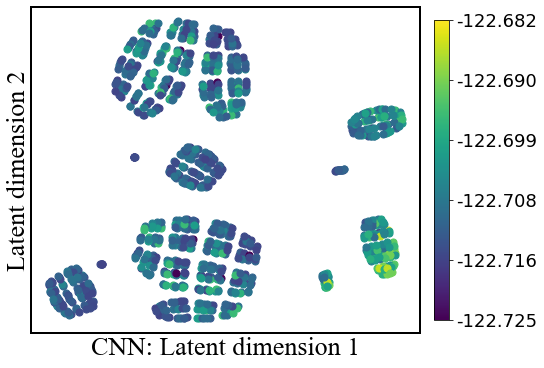

In [113]:
f=plt.figure(figsize=(8.5,6))
ax1=plt.gca()

#j=1088
for i in range(len(x)):
    color1=cm.viridis_r(int(256*(z2[i]-minz)/(maxz-minz)))
    a1=ax1.scatter(x[i],y[i],color=color1,s=50)
    #d=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
cb=plt.colorbar(a1,ax=ax1,shrink=0.92,pad=0.03)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_yticklabels(['-122.725', '-122.716', '-122.708', '-122.699', '-122.690', '-122.682'])
cb.ax.tick_params(labelsize=18)
ax1.set_xlabel('CNN: Latent dimension 1',fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.set_ylabel('Latent dimension 2',labelpad=0,fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.tick_params(labelsize=22)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.set_xticks(())
ax1.set_yticks(())
plt.savefig('model.jpg')

In [114]:
minz = np.min(z3)
maxz = np.max(z3)
print('minimum:',minz)
print('maximum:',maxz)
print('scale:',maxz-minz)
a1 = minz + 0.2 * (maxz-minz)
a2 = minz + 0.4 * (maxz-minz)
a3 = minz + 0.6 * (maxz-minz)
a4 = minz + 0.8 * (maxz-minz)
print(minz,a1,a2,a3,a4,maxz)

minimum: -122.75928395923738
maximum: -122.66700570595111
scale: 0.09227825328626693
-122.75928395923738 -122.74082830858012 -122.72237265792288 -122.70391700726562 -122.68546135660837 -122.66700570595111


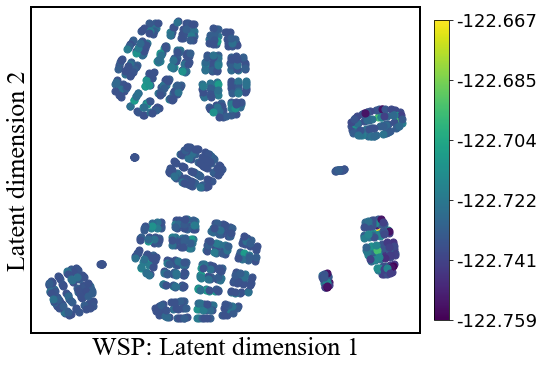

In [115]:
f=plt.figure(figsize=(8.5,6))
ax1=plt.gca()

#j=1088
for i in range(len(x)):
    color1=cm.viridis_r(int(256*(z3[i]-minz)/(maxz-minz)))
    a1=ax1.scatter(x[i],y[i],color=color1,s=50)
    #d=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
cb=plt.colorbar(a1,ax=ax1,shrink=0.92,pad=0.03)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_yticklabels(['-122.759', '-122.741', '-122.722', '-122.704', '-122.685', '-122.667'])
cb.ax.tick_params(labelsize=18)
ax1.set_xlabel('WSP: Latent dimension 1',fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.set_ylabel('Latent dimension 2',labelpad=0,fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.tick_params(labelsize=22)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.set_xticks(())
ax1.set_yticks(())
plt.savefig('WSPmodel.jpg')

In [116]:
minz = np.min(z4)
maxz = np.max(z4)
print('minimum:',minz)
print('maximum:',maxz)
print('scale:',maxz-minz)
a1 = minz + 0.2 * (maxz-minz)
a2 = minz + 0.4 * (maxz-minz)
a3 = minz + 0.6 * (maxz-minz)
a4 = minz + 0.8 * (maxz-minz)
print(minz,a1,a2,a3,a4,maxz)

minimum: -122.69459133476256
maximum: -122.69058573200047
scale: 0.004005602762092053
-122.69459133476256 -122.69379021421014 -122.69298909365773 -122.6921879731053 -122.6913868525529 -122.69058573200047


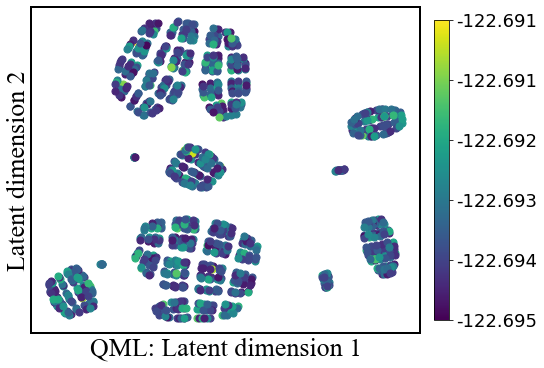

In [117]:
f=plt.figure(figsize=(8.5,6))
ax1=plt.gca()

#j=1088
for i in range(len(x)):
    color1=cm.viridis_r(int(256*(z4[i]-minz)/(maxz-minz)))
    a1=ax1.scatter(x[i],y[i],color=color1,s=50)
    #d=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
cb=plt.colorbar(a1,ax=ax1,shrink=0.92,pad=0.03)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_yticklabels(['-122.695', '-122.694', '-122.693', '-122.692', '-122.691', '-122.691'])
cb.ax.tick_params(labelsize=18)
ax1.set_xlabel('QML: Latent dimension 1',fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.set_ylabel('Latent dimension 2',labelpad=0,fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.tick_params(labelsize=22)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.set_xticks(())
ax1.set_yticks(())
plt.savefig('QMLmodel.jpg')

可视化-C
---
Visualisation: Scheme C

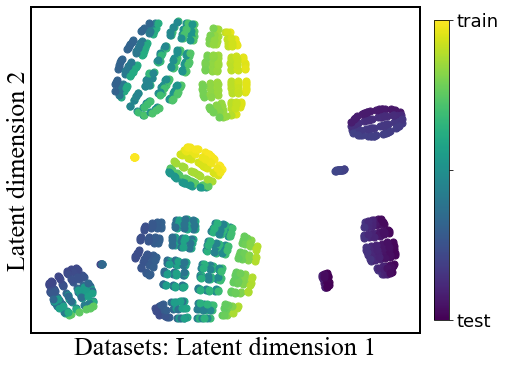

In [118]:
f=plt.figure(figsize=(8.5,6))
ax1=plt.gca()

#j=1088
for i in range(len(x)):
    if flag[i] < '00500':
        color1=cm.viridis_r(int(256*(int(flag[i]))/(1000)))
        a1=ax1.scatter(x[i],y[i],color=color1,s=50)
    else:
        color2=cm.viridis_r(int(256*(int(flag[i]))/(1000)))
        a1=ax1.scatter(x[i],y[i],color=color2,s=50)
            
    #color1=cm.viridis_r(int(256*(z4[i]-minz)/(maxz-minz)))
    #a1=ax1.scatter(x[i],y[i],color=color1,s=50)
    #d=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
cb=plt.colorbar(a1,ax=ax1,shrink=0.92,pad=0.03)
cb.set_ticks([0,0.5,1])
cb.ax.set_yticklabels(['test', ' ','train'])
cb.ax.tick_params(labelsize=18)
ax1.set_xlabel('Datasets: Latent dimension 1',fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.set_ylabel('Latent dimension 2',labelpad=0,fontdict={'family':'Times New Roman','size':'26','fontstyle':'normal','fontweight':'normal'})
ax1.tick_params(labelsize=22)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.set_xticks(())
ax1.set_yticks(())
plt.savefig('Train-Test.jpg')